# Linear Regression

The idea of this mini-project is to apply a linear regression to predict a patient's medical cost

Dataset:
https://www.kaggle.com/code/sudhirnl7/linear-regression-tutorial/data

## Steps:
  - Prepare data for use
    - Read
    - Clean
    - Separate
  - Plot information to gain insights
  - Train a model
  - Checking the results

## Importing libs

In [458]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import max_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, mean_squared_error, median_absolute_error, r2_score

In [459]:
warnings.filterwarnings('ignore')

## Loading and viewing data

In [460]:
# Carregando os dados
df = pd.read_csv('./data/insurance.csv', delimiter = ',', encoding = 'utf-8')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [461]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [462]:
# stats of numerical data
round (df.describe(exclude = 'object'), 2)

,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


In [463]:
# stats of categorical data
round (df.describe(exclude = ['float', 'int64']),2)

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [464]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

So, we see that there are no missing values in the database.

## Data Preprocessing

In [465]:
# Encode categorical columns
df = pd.get_dummies(df, columns=["sex", "smoker", "region"])
df.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,True,False,False,True,False,False,False,True
1,18,33.770,1,1725.55230,False,True,True,False,False,False,True,False
2,28,33.000,3,4449.46200,False,True,True,False,False,False,True,False
3,33,22.705,0,21984.47061,False,True,True,False,False,True,False,False
4,32,28.880,0,3866.85520,False,True,True,False,False,True,False,False


## Exploring the data

### Distribution of "Charges"

Text(0.5, 1.0, 'Distribution of charges')

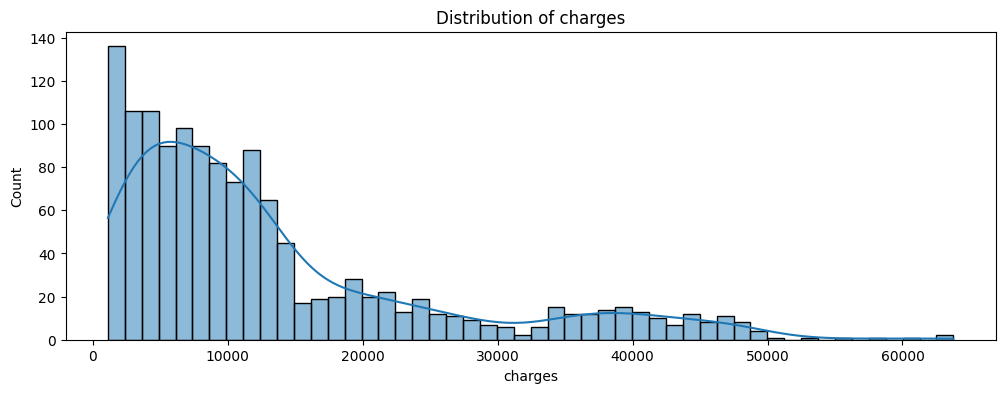

In [466]:
# Plot using seaborn
# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the distribution using histplot
sns.histplot(data=df, x='charges', kde=True, bins=50, ax=ax)
ax.set_title('Distribution of charges')

### How are the features related

Text(0.5, 1.0, 'Correlation Plot')

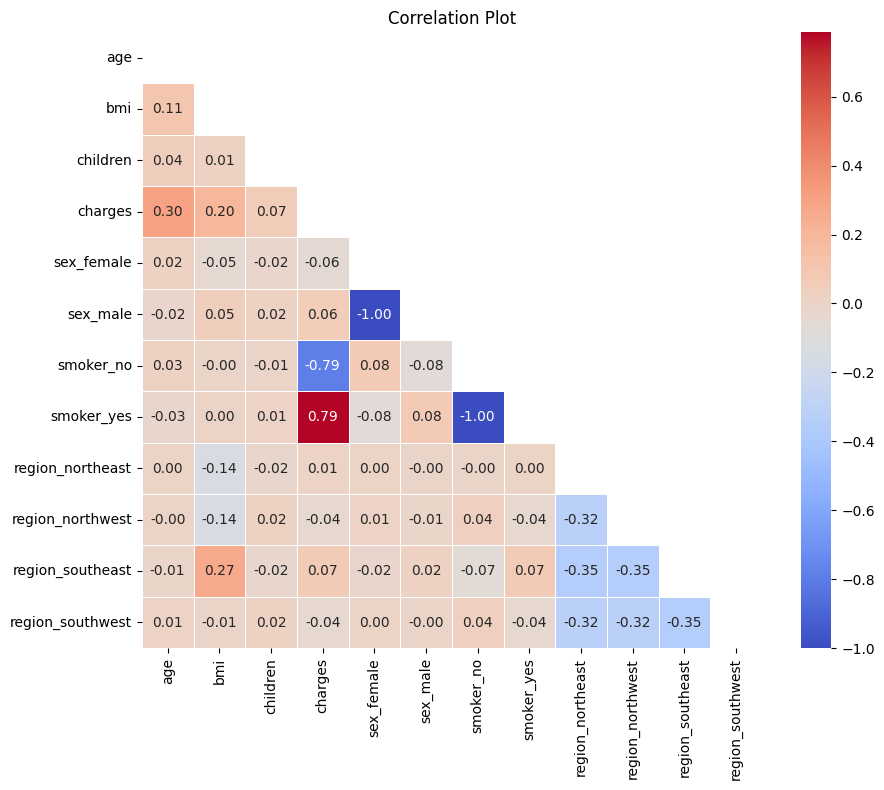

In [467]:
# Correlation plot with adjustments
corr = df.corr()

# Create a mask to hide the upper triangle (redundant information)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Plot')

We can see that the there are a stronge correlation about the smoke status and the charges cost. Also, the age is a bit correlated to the charge cost too.

### How does BMI relate to Charge

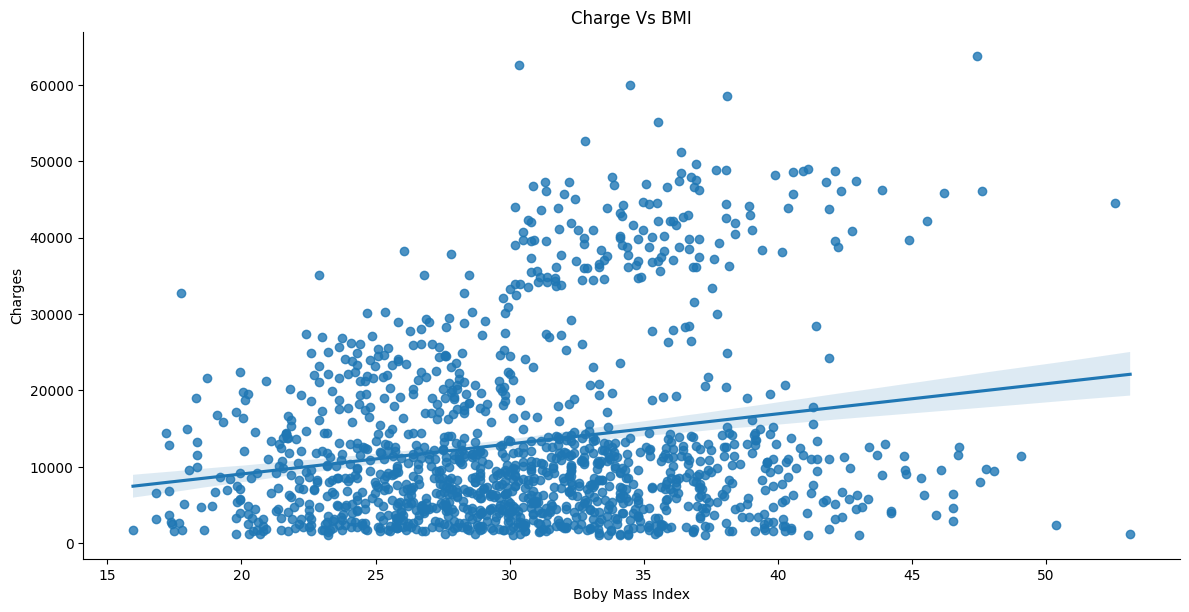

In [468]:
sns.lmplot(x='bmi', y='charges', data=df, aspect=2, height=6)
plt.xlabel('Boby Mass Index')
plt.ylabel('Charges')
plt.title('Charge Vs BMI');

### How does the smoke relate to the charge cost

Text(0, 0.5, 'Charges')

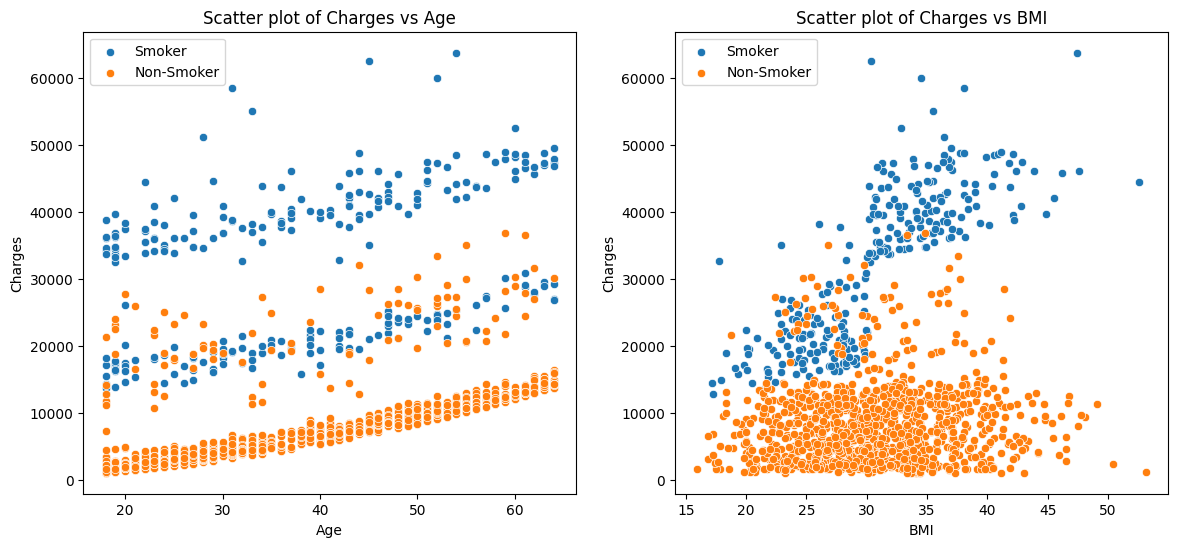

In [469]:
# Plotting Charges vs Age and Charges vs BMI for smokers and non-smokers
fig = plt.figure(figsize=(14, 6))

# Subplot 1: Charges vs Age
ax1 = fig.add_subplot(121)
sns.scatterplot(x='age', y='charges', data=df[df['smoker_yes'] == 1], palette='magma', ax=ax1)
sns.scatterplot(x='age', y='charges', data=df[df['smoker_no'] == 1], palette='viridis', ax=ax1)
ax1.legend(['Smoker', 'Non-Smoker'])
ax1.set_title('Scatter plot of Charges vs Age')
ax1.set_xlabel('Age')
ax1.set_ylabel('Charges')

# Subplot 2: Charges vs BMI
ax2 = fig.add_subplot(122)
sns.scatterplot(x='bmi', y='charges', data=df[df['smoker_yes'] == 1], palette='magma', ax=ax2)
sns.scatterplot(x='bmi', y='charges', data=df[df['smoker_no'] == 1], palette='viridis', ax=ax2)
ax2.legend(['Smoker', 'Non-Smoker'])
ax2.set_title('Scatter plot of Charges vs BMI')
ax2.set_xlabel('BMI')
ax2.set_ylabel('Charges')

Smoke has a realy bug impact in the charge cost.

## Creating and training the model

### Train Test Split

In [470]:
X = df.drop('charges', axis=1)
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)

### Training Linear Regression Model

In [471]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

### Training SGD Regression Model

In [472]:
model_SGD = SGDRegressor()
model_SGD.fit(X_train, y_train)

SGDRegressor()

### Making predictions using the trained models

In [473]:
y_pred_lr = model_lr.predict(X_test)
y_pred_SGD = model_SGD.predict(X_test)

### Comparing Real and Predicted Values

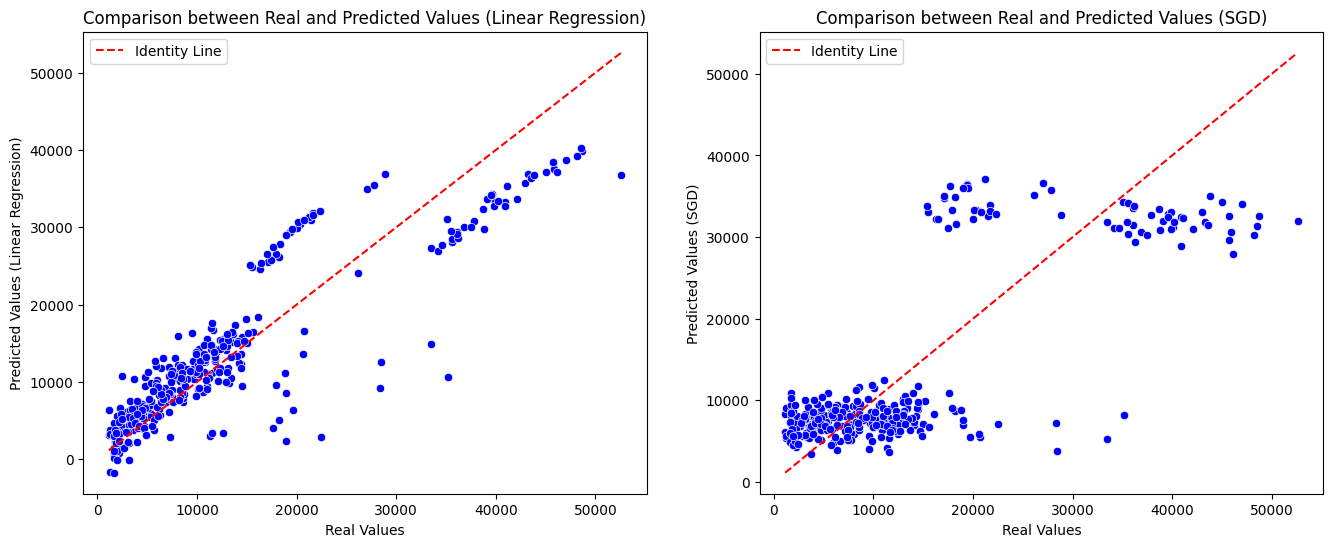

In [474]:
# Creating a DataFrame with the data
df_y = pd.DataFrame({'y_test': y_test, 'y_pred_lr': y_pred_lr, 'y_pred_SGD': y_pred_SGD})

# Creating the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plotting real vs predicted values for Linear Regression on ax1
sns.scatterplot(data=df_y, x='y_test', y='y_pred_lr', color='blue', ax=ax1)
sns.lineplot(x=df_y['y_test'], y=df_y['y_test'], color='red', linestyle='--', label='Identity Line', ax=ax1)
ax1.set_xlabel('Real Values')
ax1.set_ylabel('Predicted Values (Linear Regression)')
ax1.set_title('Comparison between Real and Predicted Values (Linear Regression)')
ax1.legend()

# Plotting real vs predicted values for SGD on ax2
sns.scatterplot(data=df_y, x='y_test', y='y_pred_SGD', color='blue', ax=ax2)
sns.lineplot(x=df_y['y_test'], y=df_y['y_test'], color='red', linestyle='--', label='Identity Line', ax=ax2)
ax2.set_xlabel('Real Values')
ax2.set_ylabel('Predicted Values (SGD)')
ax2.set_title('Comparison between Real and Predicted Values (SGD)')
ax2.legend()

### Checking the metrics

In [475]:
# Calculate metrics for Linear Regression
mae_lr          = mean_absolute_error(y_test, y_pred_lr)
mse_lr          = mean_squared_error(y_test, y_pred_lr)
rmse_lr         = mean_squared_error(y_test, y_pred_lr, squared=False)  # Calculate RMSE separately
mape_lr         = mean_absolute_percentage_error(y_test, y_pred_lr)
r2_lr           = r2_score(y_test, y_pred_lr)
median_ae_lr    = median_absolute_error(y_test, y_pred_lr)
max_err_lr      = max_error(y_test, y_pred_lr)

# Calculate metrics for SGD
mae_SGD         = mean_absolute_error(y_test, y_pred_SGD)
mse_SGD         = mean_squared_error(y_test, y_pred_SGD)
rmse_SGD        = mean_squared_error(y_test, y_pred_SGD, squared=False)  # Calculate RMSE separately
mape_SGD        = mean_absolute_percentage_error(y_test, y_pred_SGD)
r2_SGD          = r2_score(y_test, y_pred_SGD)
median_ae_SGD   = median_absolute_error(y_test, y_pred_SGD)
max_err_SGD     = max_error(y_test, y_pred_SGD)

# Print metrics side-by-side
print(f"{'Metric':<30} {'Linear Regression':<20} {'SGD':<20}")
print('-' * 70)
print(f"Mean Absolute Error:            {mae_lr:<20.2f} {mae_SGD:<20.2f}")
print(f"Mean Squared Error:             {mse_lr:<20.2f} {mse_SGD:<20.2f}")
print(f"Root Mean Squared Error:        {rmse_lr:<20.2f} {rmse_SGD:<20.2f}")
print(f"Mean Absolute Percentage Error: {mape_lr:<20.2%} {mape_SGD:<20.2%}")
print(f"R^2 Score:                      {r2_lr:<20.2f} {r2_SGD:<20.2f}")
print(f"Median Absolute Error:          {median_ae_lr:<20.2f} {median_ae_SGD:<20.2f}")
print(f"Max Error:                      {max_err_lr:<20.2f} {max_err_SGD:<20.2f}")

Metric                         Linear Regression    SGD                 
----------------------------------------------------------------------
Mean Absolute Error:            3893.83              5522.14             
Mean Squared Error:             29096294.22          54278433.23         
Root Mean Squared Error:        5394.10              7367.39             
Mean Absolute Percentage Error: 42.40%               74.02%              
R^2 Score:                      0.80                 0.62                
Median Absolute Error:          2503.56              4108.99             
Max Error:                      24574.99             28244.88            
